# Elevation handler
Firstly, the neccesary dependencies are imported:

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import gzip
import os
from matplotlib.patches import Rectangle
import pyproj
from scipy.interpolate import RectBivariateSpline
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs
from matplotlib.ticker import AutoLocator

For map data the Shuttle Radar Topography Mission 30-Meter SRTM Elevation Data is used. The data can be downloaded in a resolution of 1° x 1°.

In [44]:
def download_elevation(map_boundaries):

    long_min = np.minimum(map_boundaries[0], map_boundaries[1])
    long_max = np.maximum(map_boundaries[0], map_boundaries[1])
    lat_min = np.minimum(map_boundaries[2], map_boundaries[3])
    lat_max = np.maximum(map_boundaries[2], map_boundaries[3])

    long_range = np.arange(np.floor(long_min), np.ceil(long_max), 1)
    lat_range = np.arange(np.floor(lat_min), np.ceil(lat_max), 1)

    merged_map = np.zeros([len(lat_range)*3601, len(long_range)*3601])

    for i, latitude in enumerate(lat_range):
        for j, longitude in enumerate(long_range):
            if latitude < 0:
                lat_str = "S"+str(int(np.floor(-latitude))).zfill(2)
            else:
                lat_str = "N"+str(int(np.floor(latitude))).zfill(2)
                
            if longitude < 0:
                long_str = "W"+str(int(np.floor(-longitude))).zfill(3)
            else:
                long_str = "E"+str(int(np.floor(longitude))).zfill(3)

            output_name = f"{lat_str}{long_str}"
            hgt_gz_file = "../temp/"+output_name+".hgt.gz"
            hgt_file = '../temp/'+ output_name+ '.hgt'
            # tif_file = '../temp/'+ output_name+ '.tif'

            if os.path.exists(hgt_file):
                # print("File exists!")
                pass
            else:
                print("File does not exist.")

                url = f"https://s3.amazonaws.com/elevation-tiles-prod/skadi/{lat_str}/{output_name}"+".hgt.gz"
                
                urllib.request.urlretrieve(url, hgt_gz_file)

                with gzip.open(hgt_gz_file, 'rb') as f_in:
                    with open(hgt_file, 'wb') as f_out:
                        f_out.write(f_in.read())
                os.remove(hgt_gz_file)
            
            with open(hgt_file, 'rb') as f:
                data = np.frombuffer(f.read(), np.dtype('>i2')).reshape((3601, 3601))
                data = np.flip(data, axis=0)

            merged_map[i*3601:(i+1)*3601, j*3601:(j+1)*3601] = data

    srtm_latitude = np.linspace(np.floor(lat_min), np.ceil(lat_max), merged_map.shape[0])
    srtm_longitude = np.linspace(np.floor(long_min), np.ceil(long_max), merged_map.shape[1])

    return srtm_longitude, srtm_latitude, merged_map

Now let's test the function.

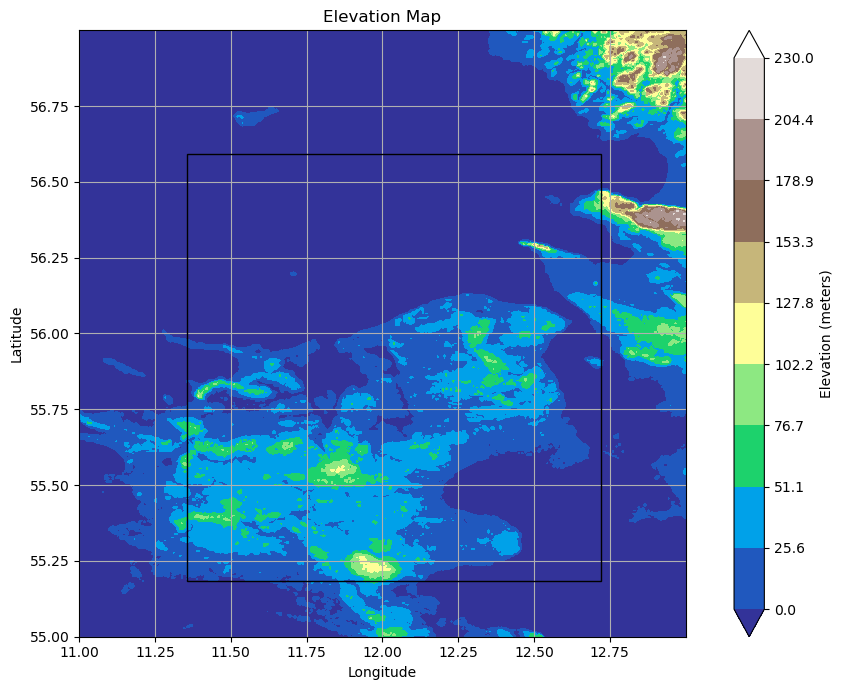

In [45]:
map_boundaries = np.array([11.356, 12.72, 55.184, 56.593]) # longitude, latitude
#  45.184824127006706, 6.356677460471748 47.5930208421994, 9.723481445784927
# map_boundaries = np.array([55.22, 55.7, 12.42, 12.7])

srtm_longitude, srtm_latitude, merged_map = download_elevation(map_boundaries)
scale = 20

vmin = 0
vmax = float('%.2g' % np.max(merged_map)) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))
ct = ax.contourf(srtm_longitude[::scale], srtm_latitude[::scale], merged_map[::scale, ::scale], 
                 levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                 cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

# Add the rectangle to the plot
rect = Rectangle(
    xy=(map_boundaries[0], map_boundaries[2]),  # bottom-left corner
    width=(map_boundaries[1] - map_boundaries[0]),  # width
    height=(map_boundaries[3] - map_boundaries[2]),  # height
    linewidth=1,
    edgecolor='k',
    facecolor='none'
)

ax.add_patch(rect)
rect.set_zorder(3)

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

As the dataset is too large to work with, a function is used to scale it down.

In [46]:
def scale_array_func(array, long_list, lat_list, new_shape = None, scaling_factor = None):
        """
        Input:
            array : np.array (2D)
            long_list : np.array (1D)
            lat_list : np.array (1D)
            new_shape : list or tuple or np.array
            scaling_factor : float
        """

        old_shape = np.asarray(np.shape(array))


        if (new_shape is not None) or (scaling_factor is not None):

            scaled_shape = old_shape
            new_shape = np.asarray(new_shape)

            if new_shape is not None:
                scaled_shape = new_shape

            if scaling_factor is not None:
                scaled_shape = np.round(scaled_shape * scaling_factor).astype(int)
        else:
            raise ValueError("To scale an array, either the new shape or scaling factor is needed.")
        
        # make points from 0 to 1 for the length of the shape
        x = np.linspace(0, 1, old_shape[0])
        y = np.linspace(0, 1, old_shape[1])

        interp_spline = RectBivariateSpline(x, y, array)
            
        x2 = np.linspace(0, 1, scaled_shape[0])   
        y2 = np.linspace(0, 1, scaled_shape[1])
        
        scaled_array = interp_spline(x2, y2)

        scaled_long = np.interp(np.linspace(0, len(long_list) - 1, scaled_shape[0]), 
                                np.arange(len(long_list)), 
                                long_list)
        
        scaled_lat = np.interp(np.linspace(0, len(lat_list) - 1, scaled_shape[1]), 
                        np.arange(len(lat_list)), 
                        lat_list)


        return scaled_array, scaled_long, scaled_lat

merged_map, srtm_longitude, srtm_latitude = scale_array_func(merged_map, srtm_longitude, srtm_latitude, new_shape = [1000, 1000], scaling_factor = 0.25)

Now limit the of the image (Indicated by the black border)

In [47]:
def generate_subarray(original_array, long_points, col_points, subarray_bounds):

    start_long = np.argmin(np.abs(long_points - subarray_bounds[0]))
    end_long = np.argmin(np.abs(long_points - subarray_bounds[1])) 
    start_lat = np.argmin(np.abs(col_points - subarray_bounds[2]))
    end_lat = np.argmin(np.abs(col_points - subarray_bounds[3])) 
    
    subarray = original_array[start_lat:end_lat+1, start_long:end_long+1]
    subarray_bounds = [long_points[start_long], long_points[end_long], col_points[start_lat], col_points[end_lat]]
    sublong_points = long_points[start_long:end_long+1]
    sublat_points = col_points[start_lat:end_lat+1]
    
    return subarray, sublong_points, sublat_points, subarray_bounds

Test

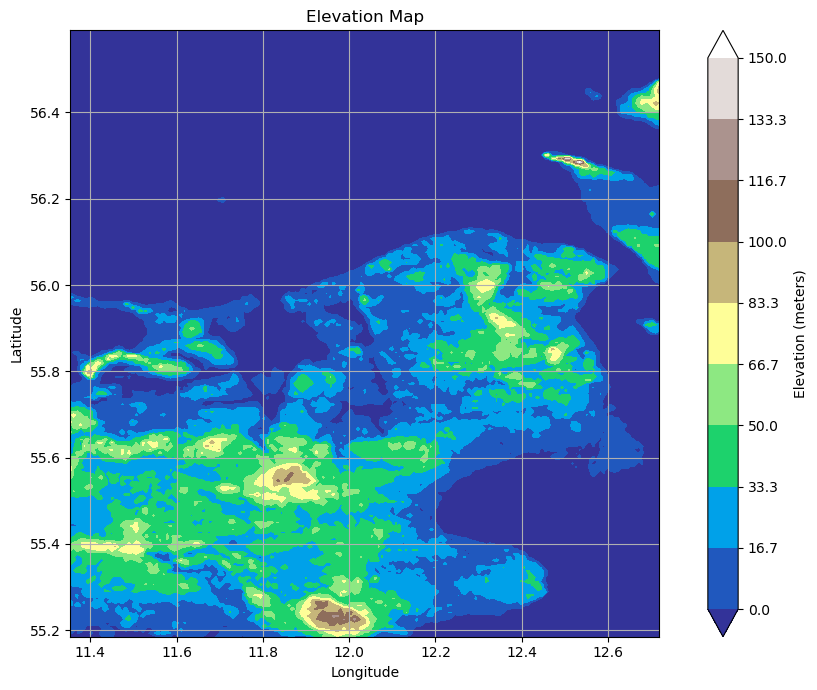

In [48]:
subarray, sublong_points, sublat_points, subarray_bounds = generate_subarray(merged_map, srtm_longitude, srtm_latitude, map_boundaries)

vmin = np.minimum(0, float('%.2g' % np.max(subarray)))
vmax = np.maximum(0, float('%.2g' % np.max(subarray))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))
ct = ax.contourf(sublong_points, sublat_points, subarray, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

Code to transform the coordinates

In [49]:
def transform_coordinates(long_list, lat_list, input_crs_str = "EPSG:4326", output_crs_str = "EPSG:3035"):
    
    input_crs = pyproj.CRS(input_crs_str)  # WGS84
    output_crs = pyproj.CRS(output_crs_str)

    transformer = pyproj.Transformer.from_crs(input_crs, output_crs, always_xy=True)

    trans_cords = np.empty([len(lat_list),len(long_list), 2])

    for i, lon in enumerate(long_list):
        for j, lat in enumerate(lat_list):
            x, y = transformer.transform(lon, lat)
            trans_cords[j, i, 0] = x
            trans_cords[j, i, 1] = y

    return trans_cords

Run the code

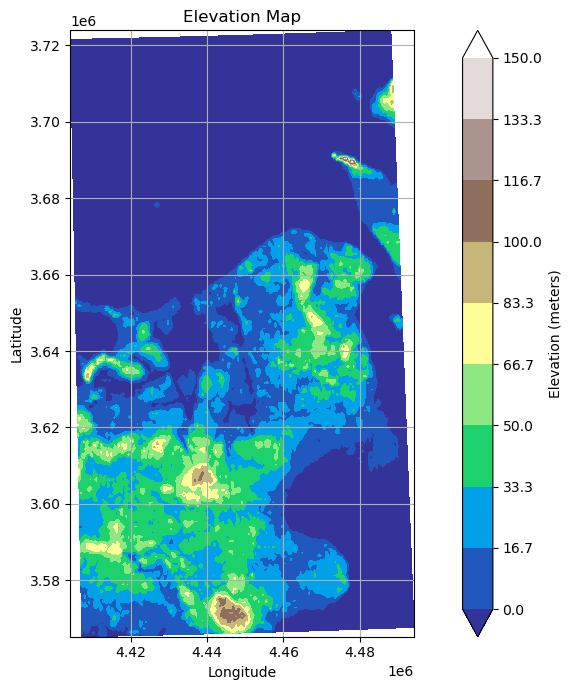

In [50]:
trans_cords = transform_coordinates(sublong_points, sublat_points, input_crs_str = "EPSG:4326", output_crs_str = "EPSG:3035")

vmin = np.minimum(0, float('%.2g' % np.max(subarray)))
vmax = np.maximum(0, float('%.2g' % np.max(subarray))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))

ct = ax.contourf(trans_cords[:,:,0], trans_cords[:,:,1], subarray, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

Add Google Maps layer

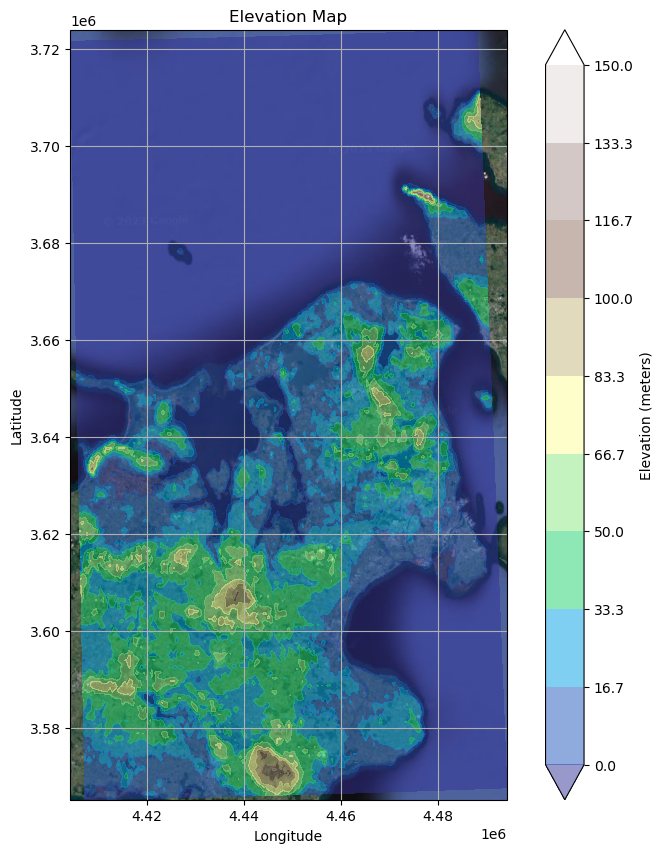

In [51]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.epsg(3035)}, figsize=(10, 10))

ct = ax.contourf(trans_cords[:,:,0], trans_cords[:,:,1], subarray, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain', alpha = 0.5)

plt.colorbar(ct, ax = ax, label='Elevation (meters)')

# ax.set_extent(map_boundaries)
imagery = GoogleTiles(style = "satellite") # Valid styles: street, satellite, terrain, only_streets
ax.add_image(imagery, 9) # 16

# For some reason, the ticks needs to be overriden ([0]) before AutoLocator can be used.
ax.set_xticks([0], crs=ccrs.epsg(3035))
ax.set_yticks([0], crs=ccrs.epsg(3035))
ax.xaxis.set_major_locator(AutoLocator())
ax.yaxis.set_major_locator(AutoLocator())

plt.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Convert map to voxel

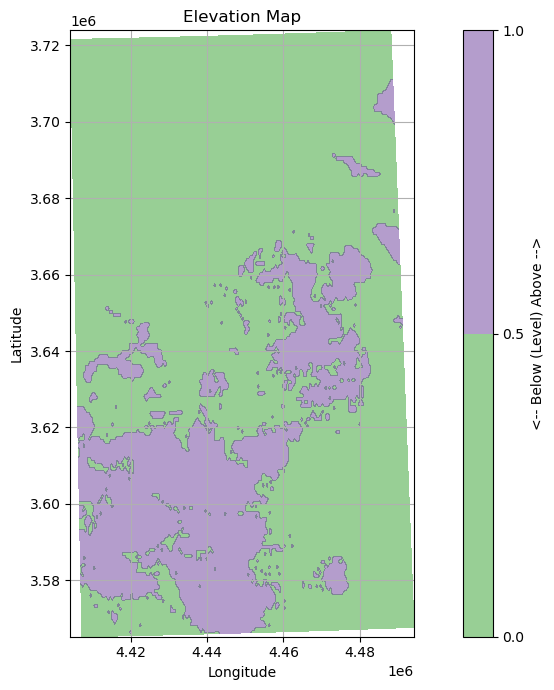

In [56]:
subarray_min = np.floor(np.min(subarray))
subarray_max = np.ceil(np.max(subarray))

elevation_range = np.arange(subarray_min, subarray_max, 1)
result_array = np.zeros((subarray.shape[0], subarray.shape[1], len(elevation_range)), dtype=bool)
for i, elev_range in enumerate(elevation_range):
    result_array[:, :, i] = subarray > elevation_range[i]

level = 75

fig, ax = plt.subplots(figsize = (10, 7))

ct = ax.contourf(trans_cords[:,:,0], trans_cords[:,:,1], result_array[:, :, level],
                cmap='Paired', alpha = 0.5)

plt.colorbar(ct, ax = ax, label='<-- Below (Level) Above -->')

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()